In [1]:
import numpy as np
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numba
from numba import prange
from time import perf_counter
from scipy.ndimage import convolve, sobel
from scipy import ndimage
from sklearn import preprocessing
from scipy.stats import mode
import seaborn as sns

from npfi import npfi, get_pdfs_from_data
# import statistics as statss
%matplotlib inline
sns.set_style("ticks")
sns.set_context("poster")

def timer(method):
    def timed(*args, **kw):
        ts = perf_counter()
        result = method(*args, **kw)
        te = perf_counter()
        tlapsed = te-ts
        print(f"{tlapsed//60} mins and {tlapsed%60:0.2f} secs")
        return result
    return timed

Didn't find DEFT package, disabling method='deft' in PDF computation.
You can obtain DEFT at:
https://github.com/jbkinney/13_deft


In [2]:
# def grierer_meinhardt(U, V, Du, Dv, c1, c2, c3, c4, c5, k, dt, dx, T, sr=5):
#     n = U.shape[0]
#     iters = int(T / dt)
#     for i in tqdm(range(iters)):
#         Lu = Du*lap_neumann(U)/dx/dx
#         Lv = Dv*lap_neumann(V)/dx/dx
#         uc = U[1:-1, 1:-1]
#         vc = V[1:-1, 1:-1]
#         U[1:-1, 1:-1], V[1:-1, 1:-1] =\
#         uc + dt*(Lu + c1 - c2*uc + c3*uc*uc/(1+k*uc*uc)/vc),\
#         vc + dt*(Lv + c4*uc*uc - c5*vc)
#         for u in (U, V):
#             u[0, :] = u[1, :]
#             u[-1, :] = u[-2, :]
#             u[:, 0] = u[:, 1]
#             u[:, -1] = u[:, -2]
#     return U, V

@timer
@numba.njit(fastmath=True, parallel=True)
def fitzhugh_nagumo(U, V, delta, eps, alpha, beta, dt, dx, T):
    n = U.shape[0]
    iters = int(T / dt)
    for i in range(iters):
#         Lu, Lv = D*lap(U, n)/dx/dx, lap(V, n)/dx/dx
        Lu, Lv = lap(U, n)/dx/dx, lap(V, n)/dx/dx
#         U, V = U + dt*(Lu - (U - R) * (U*U - 1) - p * (V-U)), V + dt*(Lv  - (V - U)) / k
        U, V = U + dt*(Lu - V + U - U**3), V + dt*(delta*Lv + eps*(U - alpha*V - beta))
#         plt.figure(figsize=(15,15))
#         plt.imshow(V, cmap='gist_earth')
# #         plt.clim(vmin=-3, vmax=3)
#         plt.colorbar()
#         plt.show()
    return U, V

def lap_neumann(u):
    return u[:-2, 1:-1] + u[2:, 1:-1] + u[1:-1, :-2] + u[1:-1, 2:] - 4*u[1:-1, 1:-1]

@numba.njit(parallel=True, fastmath=True)
def lap(u, N):
    """
    Parallel implementation of the discrete heat equation. Loops over all
    rows in parallel.
    """
    uc = np.empty((N, N))
    for x in numba.prange(1, N-1):
        uc[x, 1:-1] = u[x+1, 1:-1] + u[x-1, 1:-1] + u[x, :-2] + u[x, 2:] - 4*u[x, 1:-1]

    uc[1:-1, 0] = u[1:-1, 1] + u[:-2, 0] + u[2:, 0] + u[1:-1, -1] - 4*u[1:-1, 0]
    uc[1:-1, -1] = u[1:-1, -2] + u[:-2, -1] + u[2:, -1] + u[1:-1, 0] - 4*u[1:-1, -1]
    uc[0, 1:-1] = u[1, 1:-1] + u[0, 2:] + u[0, :-2] + u[-1, 1:-1] - 4*u[0, 1:-1]
    uc[-1, 1:-1] = u[-2, 1:-1] + u[-1, 2:] + u[-1, :-2] + u[0, 1:-1] - 4*u[-1, 1:-1]

    uc[0, 0] = u[0, 1] + u[0, -1] + u[1, 0] + u[-1, 0] - 4*u[0, 0]
    uc[-1, 0] = u[0, 0] + u[-2, 0] + u[-1, -1] + u[-1, -2] - 4*u[-1, 0]
    uc[0, -1] = u[0, 0] + u[0, -2] + u[-1, -1] + u[1, -1] - 4*u[0, -1]
    uc[-1, -1] = u[0, -1] + u[-1, 0] + u[-1, -2] + u[-2, -1] - 4*u[-1, -1]
    return uc

def convolution(mat, kernel, rep=1):
    for _ in range(rep):
        mat = convolve(mat, kernel, mode='wrap')
    return mat


8.0 mins and 53.63 secs


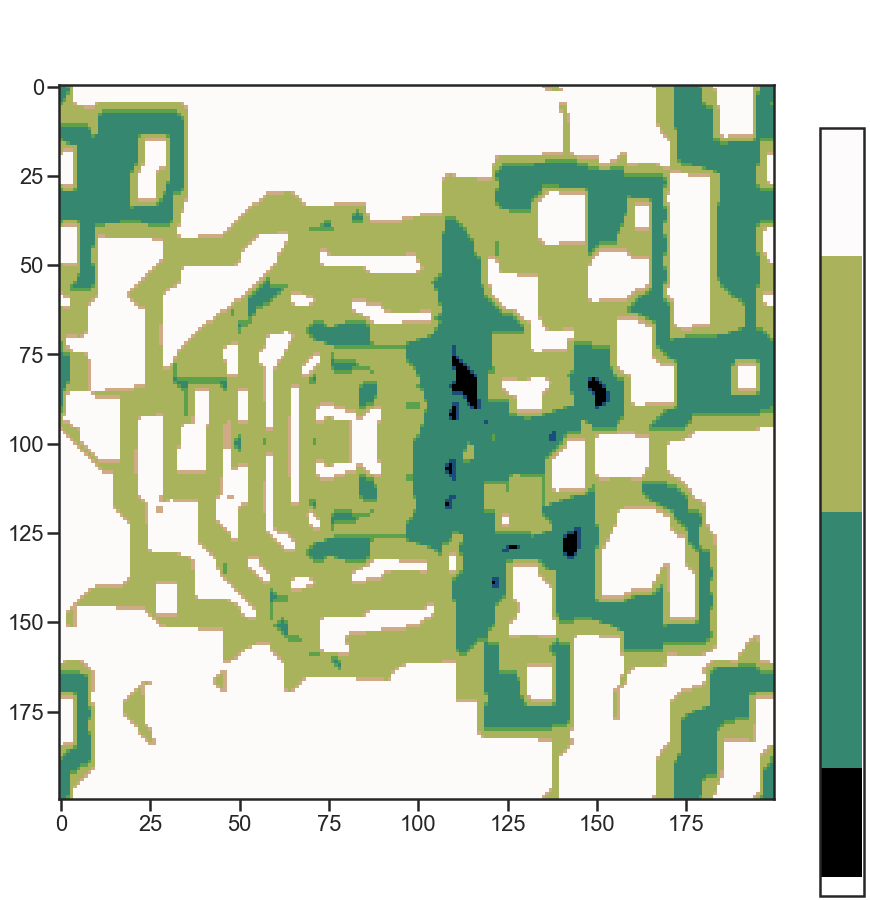

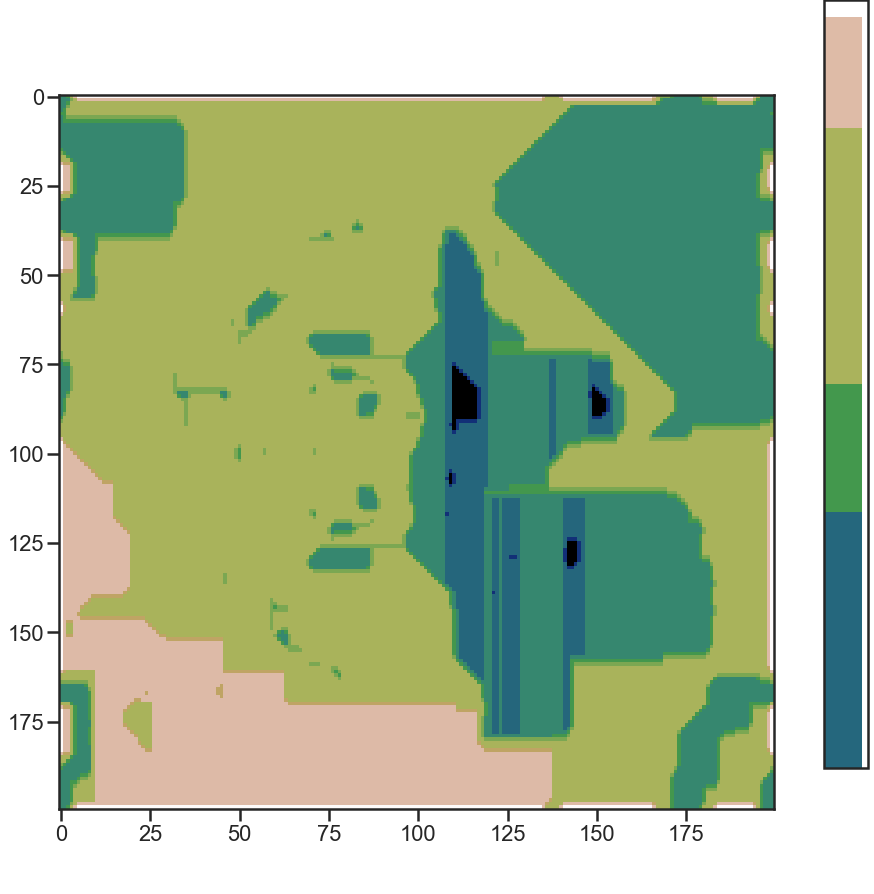

C:\Users\lenna\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\preprocessing\data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


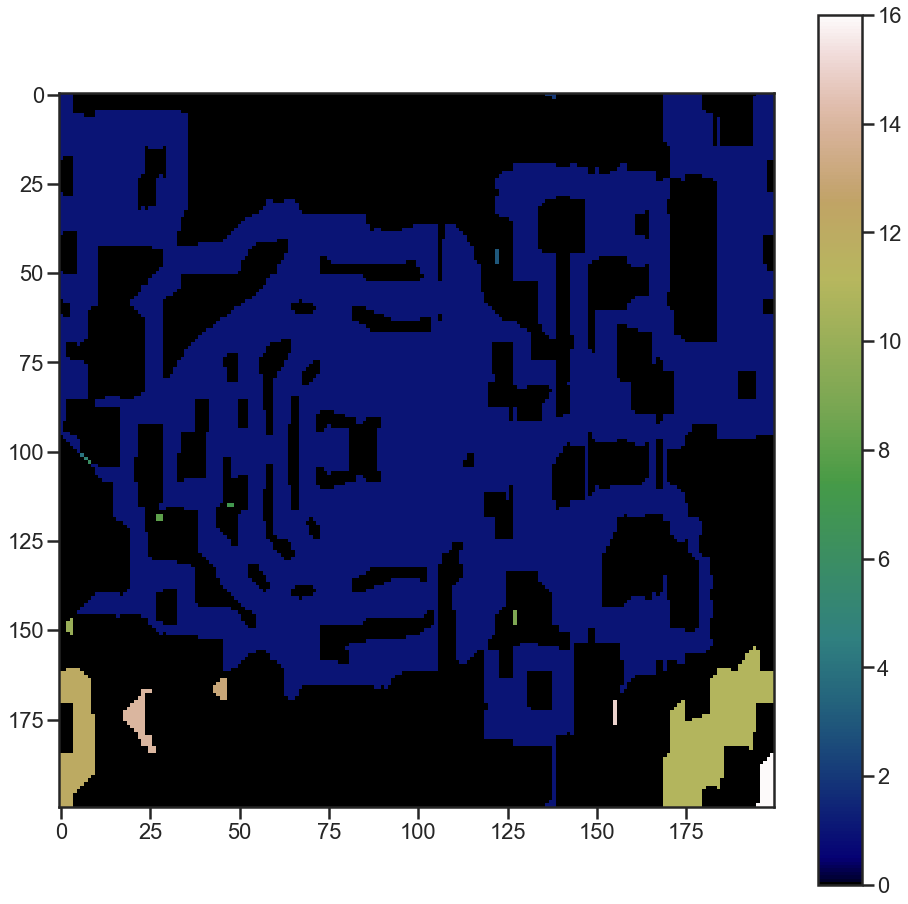

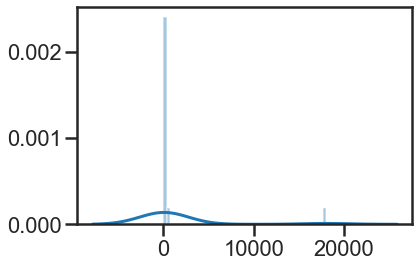

In [8]:
n = 200
# F = 0.035
# k = 0.06
T = 10000
dt = 0.01
dx = 1.0
delta = 2 #0.1
eps = 0.3 #0.12
alpha = 1.4 #1.0
beta = 0 #20.2


U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
r, m = n//40, n//2
U[...] = 1.0
V[m-r:m+r, m-r:m+r] = 0.25
V[m-r:m+r, m-r:m+r] = 0.5
u_out, v_out = fitzhugh_nagumo(U, V, delta, eps, alpha, beta, dt, dx, T)

plt.figure(figsize=(16,16))
plt.imshow(u_out, cmap='gist_earth')
plt.colorbar()
plt.show()
plt.figure(figsize=(16,16))
plt.imshow(v_out, cmap='gist_earth')
plt.colorbar()
plt.show()

binarized = np.clip(preprocessing.scale(u_out)*-1000, 0, 1)
labels = ndimage.label(binarized)
bins, edges = np.histogram(labels[0], bins=labels[1])

plt.figure(figsize=(16,16))
plt.imshow(labels[0], cmap='gist_earth')
plt.colorbar()
plt.show()
plt.figure()
sns.distplot(bins[1:])
plt.show()